In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from feature_format import featureFormat
from feature_format import targetFeatureSplit

### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi"]

### load the dictionary containing the dataset
data_dict = pickle.load(open("./data/final_project_dataset.pkl", "rb"))

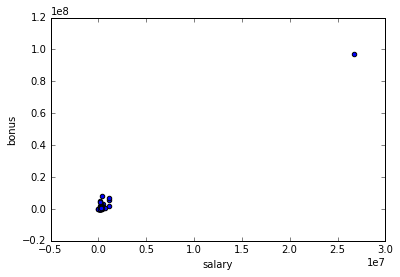

In [62]:
features = ["salary", "bonus"]
#data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)
### plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [63]:
### remove any outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
### print top 4 salaries
print(outliers_final)

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


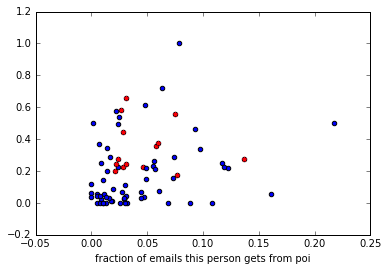

In [64]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()

In [65]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(my_dataset, features_list)

### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)



from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier(random_state=1)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print('accuracy', score)

print("Decision tree algorithm time:", round(time()-t0, 3), "s")



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print('Feature Ranking: ')
for i in range(16):
    print("{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]]))

accuracy 0.8
Decision tree algorithm time: 0.002 s
Feature Ranking: 
1 feature salary (0.21521617311091007)
2 feature bonus (0.1716491841491841)
3 feature fraction_from_poi_email (0.17008101218627533)
4 feature fraction_to_poi_email (0.12590090090090086)
5 feature deferral_payments (0.07747747747747744)
6 feature total_payments (0.07631903609626388)
7 feature loan_advances (0.07314307314307311)
8 feature restricted_stock_deferred (0.047542997542997525)
9 feature deferred_income (0.03298546070823298)
10 feature total_stock_value (0.009684684684684699)
11 feature expenses (0.0)
12 feature exercised_stock_options (0.0)
13 feature long_term_incentive (0.0)
14 feature shared_receipt_with_poi (0.0)
15 feature restricted_stock (0.0)
16 feature director_fees (0.0)


In [66]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", "shared_receipt_with_poi"]

### try Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print(accuracy)

print("NB algorithm time:", round(time()-t0, 3), "s")

0.533333333333
NB algorithm time: 0.003 s


In [67]:
### use manual tuning parameter min_samples_split
clf = DecisionTreeClassifier(min_samples_split=5, random_state=0)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print('accuracy', score)

print("Decision tree algorithm time:", round(time()-t0, 3), "s")

accuracy 0.666666666667
Decision tree algorithm time: 0.136 s


In [74]:
### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", 'shared_receipt_with_poi']


### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print('accuracy before tuning ', score)

print("Decision tree algorithm time:", round(time()-t0, 3), "s")


### use manual tuning parameter min_samples_split
t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print("Validating algorithm:")
print("accuracy after tuning = ", acc)

# function for calculation ratio of true positives
# out of all positives (true + false)
print('precision = ', precision_score(labels_test,pred))

# function for calculation ratio of true positives
# out of true positives and false negatives
print('recall = ', recall_score(labels_test,pred))


### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "wb") )
pickle.dump(data_dict, open("my_dataset.pkl", "wb") )
pickle.dump(features_list, open("my_feature_list.pkl", "wb") )

accuracy before tuning  0.821428571429
Decision tree algorithm time: 0.002 s
done in 0.001s
Validating algorithm:
accuracy after tuning =  0.821428571429
precision =  0.75
recall =  0.428571428571
